In [1]:
DATA_DIR = '../data/fhv_tripdata_2021-01.parquet'

In [85]:
import os
import math

import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer

In [106]:
import mlflow

mlflow.set_tracking_uri("sqlite:///../mlflow.db")
mlflow.set_experiment("nyc-taxi-exp")

INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2022/06/05 17:29:19 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-exp' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-exp', tags={}>

In [4]:
df = pd.read_parquet(DATA_DIR)

In [5]:
df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037
...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285


# Q1: Downloading the data

Read the data for January. How many records are there? We have **1154112** records of trips in January

In [6]:
df['duration'] = (df['dropOff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60.

In [7]:
df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
...,...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266,8.750000
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,,57.600000
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285,16.200000
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285,19.433333


In [8]:
round(df['duration'].describe(), 2)

count    1154112.00
mean          19.17
std          398.69
min            0.02
25%            7.77
50%           13.40
75%           22.28
max       423371.05
Name: duration, dtype: float64

# Q2: Computing duration
What's the average trip duration in January? The average trip duration is 19.17.

In [9]:
round(df['duration'].describe(), 2)

count    1154112.00
mean          19.17
std          398.69
min            0.02
25%            7.77
50%           13.40
75%           22.28
max       423371.05
Name: duration, dtype: float64

In [10]:
round(df['duration'].describe(percentiles=[.95, .98]), 2)

count    1154112.00
mean          19.17
std          398.69
min            0.02
50%           13.40
95%           47.25
98%           66.13
max       423371.05
Name: duration, dtype: float64

In [11]:
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

In [12]:
round(df['duration'].describe(), 2)

count    1109826.00
mean          16.25
std           11.55
min            1.00
25%            7.85
50%           13.23
75%           21.47
max           60.00
Name: duration, dtype: float64

# Data preparation
After analysis data distribution and see some outliers, we decide to focus on trips that have duration between 1 and 60.
We have dropped 1154112 - 1109826 = 44286 records.

/Users/hllj/opt/anaconda3/envs/mlops-practice/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

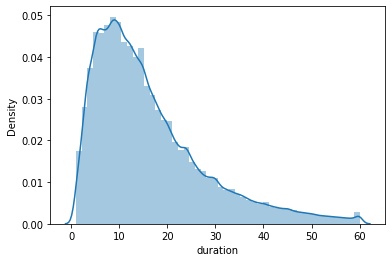

In [13]:
sns.distplot(df['duration'], kde=True, norm_hist=False)

In [14]:
is_null_pickup = pd.isnull(df['PUlocationID'])
is_null_dropoff = pd.isnull(df['DOlocationID'])

In [15]:
df[is_null_pickup | is_null_dropoff]

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.0,None,B00037,9.050000
...,...,...,...,...,...,...,...,...
1154094,B03202,2021-01-31 23:57:02,2021-02-01 00:14:27,NaN,177.0,None,B03202,17.416667
1154096,B03239,2021-01-31 23:07:00,2021-01-31 23:17:28,NaN,70.0,None,B03239,10.466667
1154097,B03239,2021-01-31 23:27:39,2021-01-31 23:33:38,NaN,82.0,None,B03239,5.983333
1154098,B03239,2021-01-31 23:40:10,2021-01-31 23:52:07,NaN,56.0,None,B03239,11.950000


In [16]:
is_null_pickup_percentage = len(df[is_null_pickup]) / len(df) * 100.0
is_null_pickup_percentage

83.52732770722618

In [17]:
is_null_dropoff_percentage = len(df[is_null_dropoff]) / len(df) * 100.0
is_null_dropoff_percentage

13.327044059158824

# Q3. Missing values
What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.
The fractions of missign values for pickup location ID is **83.5%**.

In [18]:
df['PUlocationID'].fillna(-1, inplace=True)

/Users/hllj/opt/anaconda3/envs/mlops-practice/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [19]:
df['DOlocationID'].fillna(-1, inplace=True)

In [20]:
columns = ['PUlocationID', 'DOlocationID']
target_column = ['duration']

In [21]:
feat_df = df[columns].astype('str')
target_df = df[target_column]

In [22]:
train_dicts = feat_df.to_dict(orient='records')

In [23]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [24]:
X_train.shape

(1109826, 525)

# Q4. One-hot encoding
What's the dimensionality of this matrix? (The number of columns).
We have 525 dimensions of feature matrix.

In [25]:
linear_regression_model = LinearRegression()

In [26]:
y_train = target_df.values

In [27]:
X_train.shape

(1109826, 525)

In [28]:
y_train.shape

(1109826, 1)

In [29]:
linear_regression_model.fit(X_train, y_train)

LinearRegression()

In [30]:
y_pred = linear_regression_model.predict(X_train)

In [35]:
mse = mean_squared_error(y_train, y_pred)

In [36]:
rmse = math.sqrt(mse)

In [37]:
rmse

10.528519107213953

# Q5. Training a model

What's the RMSE on train?

Root mean squared error on training dataset is **10.52**.

In [38]:
VAL_DATA_DIR = '../data/fhv_tripdata_2021-02.parquet'

In [39]:
val_df = pd.read_parquet(VAL_DATA_DIR)

In [40]:
val_df['duration'] = (val_df['dropOff_datetime'] - val_df['pickup_datetime']).dt.total_seconds() / 60.

In [41]:
val_df = val_df[(val_df['duration'] >= 1) & (val_df['duration'] <= 60)]

In [42]:
val_df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173.0,82.0,None,B00021,10.666667
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173.0,56.0,None,B00021,14.566667
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82.0,129.0,None,B00021,7.950000
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,NaN,225.0,None,B00037,13.800000
5,B00037,2021-02-01 00:00:37,2021-02-01 00:09:35,NaN,61.0,None,B00037,8.966667
...,...,...,...,...,...,...,...,...
1037687,B03282,2021-02-28 23:01:16,2021-02-28 23:14:48,NaN,31.0,None,B01717,13.533333
1037688,B03282,2021-02-28 23:36:10,2021-02-28 23:47:38,NaN,169.0,None,B01717,11.466667
1037689,B03285,2021-02-28 23:18:36,2021-02-28 23:43:59,28.0,171.0,None,B03285,25.383333
1037690,B03285,2021-02-28 23:26:34,2021-02-28 23:44:37,16.0,252.0,None,B03285,18.050000


In [43]:
val_df['PUlocationID'].fillna(-1, inplace=True)
val_df['DOlocationID'].fillna(-1, inplace=True)

In [44]:
feat_val_df = val_df[columns].astype('str')
target_val_df = val_df[target_column]

In [45]:
val_dicts = feat_val_df.to_dict(orient='records')

In [46]:
X_val = dv.transform(val_dicts)
X_val.shape

(990113, 525)

In [47]:
y_val = target_val_df.values
y_val.shape

(990113, 1)

In [48]:
y_val_pred = linear_regression_model.predict(X_val)

In [49]:
mse = mean_squared_error(y_val, y_val_pred)

In [50]:
rmse = math.sqrt(mse)

In [51]:
rmse

11.014283225612353

# Q6. Evaluating the model

What's the RMSE on validation?

Root mean squared error on validation dataset is 11.01

# Clean functions and refactoring:

In [83]:
CUR_DIR = os.getcwd()

In [60]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = (df['dropOff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60.
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
    return df

def prepare_data(df, columns, target_column, is_train=True, dv=None):
    df['PUlocationID'].fillna(-1, inplace=True)
    df['DOlocationID'].fillna(-1, inplace=True)
    feat_df = df[columns].astype('str')
    target_df = df[target_column]
    dicts = feat_df.to_dict(orient='records')
    if is_train:
        dv = DictVectorizer()
        X = dv.fit_transform(dicts)
        y = target_df.values
        return X, y, dv
    else:
        X = dv.transform(dicts)
        y = target_df.values
        return X, y, dv

In [56]:
TRAIN_DATA_DIR = '../data/fhv_tripdata_2021-01.parquet'
VAL_DATA_DIR = '../data/fhv_tripdata_2021-02.parquet'

In [57]:
train_df = read_dataframe(TRAIN_DATA_DIR)
val_df = read_dataframe(VAL_DATA_DIR)

In [61]:
columns = ['PUlocationID', 'DOlocationID']
target_column = ['duration']

In [62]:
X_train, y_train, dv = prepare_data(train_df, columns, target_column, is_train=True, dv=None)

In [65]:
X_val, y_val, dv = prepare_data(val_df, columns, target_column, is_train=False, dv=dv)

In [99]:
def train(X, y, model):
    model.fit(X_train, y_train)
    return model

def score(X, y, model):
    y_pred = model.predict(X)
    rmse = mean_squared_error(y, y_pred, squared=False)
    return rmse

In [100]:
lr_model = LinearRegression()
lr_model = train(X_train, y_train, lr_model)
train_rmse = score(X_train, y_train, lr_model)
val_rmse = score(X_val, y_val, lr_model)
print(train_rmse, val_rmse)

10.528519107213953 11.014283225612353


In [101]:
with open('../models/lin_reg.bin', 'wb') as f:
    pickle.dump((dv, lr_model), f)

In [107]:
with mlflow.start_run():
    mlflow.set_tag("developer", "hopbui")
    
    mlflow.log_param("train-data-path", TRAIN_DATA_DIR)
    mlflow.log_param("val-data-path", VAL_DATA_DIR)
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr_lasso = Lasso(alpha)
    lr_lasso = train(X_train, y_train, lr_lasso)
    train_rmse = score(X_train, y_train, lr_lasso)
    val_rmse = score(X_val, y_val, lr_lasso)
    mlflow.log_metric("rmse", val_rmse)
    with open('../models/lin_reg.bin', 'wb') as f:
        pickle.dump((dv, lr_model), f)
    mlflow.log_artifact(local_path='../models/lin_reg.bin', artifact_path="models_pickle")

# Use Xgboost model and search hyperparams with hyperopt

In [110]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


In [114]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [117]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
    return {"loss": rmse, "status": STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[17:48:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.50953                                                                                         
[1]	validation-rmse:18.80881                                                                                         
[2]	validation-rmse:18.15870                                                                                         
[3]	validation-rmse:17.55546                                                                                         
[4]	validation-rmse:16.99734                                                                                         
[5]	validation-rmse:16.48033                                                                                         
[6]	validation-rmse:16.00260                                                        

[67]	validation-rmse:10.72239                                                                                        
[68]	validation-rmse:10.71953                                                                                        
[69]	validation-rmse:10.71644                                                                                        
[70]	validation-rmse:10.71318                                                                                        
[71]	validation-rmse:10.71011                                                                                        
[72]	validation-rmse:10.70760                                                                                        
[73]	validation-rmse:10.70479                                                                                        
[74]	validation-rmse:10.70259                                                                                        
[75]	validation-rmse:10.70047                           

[34]	validation-rmse:11.33260                                                                                        
[35]	validation-rmse:11.31336                                                                                        
[36]	validation-rmse:11.29653                                                                                        
[37]	validation-rmse:11.28089                                                                                        
[38]	validation-rmse:11.26682                                                                                        
[39]	validation-rmse:11.25332                                                                                        
[40]	validation-rmse:11.24178                                                                                        
[41]	validation-rmse:11.23056                                                                                        
[42]	validation-rmse:11.22088                           

[1]	validation-rmse:11.32668                                                                                         
[2]	validation-rmse:10.90554                                                                                         
[3]	validation-rmse:10.78965                                                                                         
[4]	validation-rmse:10.74857                                                                                         
[5]	validation-rmse:10.72698                                                                                         
[6]	validation-rmse:10.71160                                                                                         
[7]	validation-rmse:10.70115                                                                                         
[8]	validation-rmse:10.69725                                                                                         
[9]	validation-rmse:10.69320                            

[70]	validation-rmse:10.63118                                                                                        
[71]	validation-rmse:10.63092                                                                                        
[72]	validation-rmse:10.63084                                                                                        
[73]	validation-rmse:10.63073                                                                                        
[74]	validation-rmse:10.63073                                                                                        
[75]	validation-rmse:10.63030                                                                                        
[76]	validation-rmse:10.63029                                                                                        
[77]	validation-rmse:10.62987                                                                                        
[78]	validation-rmse:10.62971                           

[37]	validation-rmse:10.66398                                                                                        
[38]	validation-rmse:10.66230                                                                                        
[39]	validation-rmse:10.65848                                                                                        
[40]	validation-rmse:10.65670                                                                                        
[41]	validation-rmse:10.65314                                                                                        
[42]	validation-rmse:10.65215                                                                                        
[43]	validation-rmse:10.65025                                                                                        
[44]	validation-rmse:10.64907                                                                                        
[45]	validation-rmse:10.64770                           

[4]	validation-rmse:16.91520                                                                                         
[5]	validation-rmse:16.39528                                                                                         
[6]	validation-rmse:15.91652                                                                                         
[7]	validation-rmse:15.47775                                                                                         
[8]	validation-rmse:15.07624                                                                                         
[9]	validation-rmse:14.70839                                                                                         
[10]	validation-rmse:14.37192                                                                                        
[11]	validation-rmse:14.06551                                                                                        
[12]	validation-rmse:13.78674                           

[73]	validation-rmse:10.94714                                                                                        
[74]	validation-rmse:10.94440                                                                                        
[75]	validation-rmse:10.94164                                                                                        
[76]	validation-rmse:10.93928                                                                                        
[77]	validation-rmse:10.93615                                                                                        
[78]	validation-rmse:10.93315                                                                                        
[79]	validation-rmse:10.93067                                                                                        
[80]	validation-rmse:10.92851                                                                                        
[81]	validation-rmse:10.92644                           

[40]	validation-rmse:10.68817                                                                                        
[41]	validation-rmse:10.68753                                                                                        
[42]	validation-rmse:10.68688                                                                                        
[43]	validation-rmse:10.68633                                                                                        
[44]	validation-rmse:10.68584                                                                                        
[45]	validation-rmse:10.68499                                                                                        
[46]	validation-rmse:10.68414                                                                                        
[47]	validation-rmse:10.68383                                                                                        
[48]	validation-rmse:10.68298                           

[7]	validation-rmse:10.82544                                                                                         
[8]	validation-rmse:10.77496                                                                                         
[9]	validation-rmse:10.74365                                                                                         
[10]	validation-rmse:10.72317                                                                                        
[11]	validation-rmse:10.71044                                                                                        
[12]	validation-rmse:10.70102                                                                                        
[13]	validation-rmse:10.69288                                                                                        
[14]	validation-rmse:10.68703                                                                                        
[15]	validation-rmse:10.68348                           

[76]	validation-rmse:10.62898                                                                                        
[77]	validation-rmse:10.62885                                                                                        
[78]	validation-rmse:10.62836                                                                                        
[79]	validation-rmse:10.62795                                                                                        
[80]	validation-rmse:10.62775                                                                                        
[81]	validation-rmse:10.62728                                                                                        
[82]	validation-rmse:10.62686                                                                                        
[83]	validation-rmse:10.62616                                                                                        
[84]	validation-rmse:10.62598                           

[43]	validation-rmse:10.58503                                                                                        
[44]	validation-rmse:10.58499                                                                                        
[45]	validation-rmse:10.58499                                                                                        
[46]	validation-rmse:10.58497                                                                                        
[47]	validation-rmse:10.58488                                                                                        
[48]	validation-rmse:10.58475                                                                                        
[49]	validation-rmse:10.58465                                                                                        
[50]	validation-rmse:10.58453                                                                                        
[51]	validation-rmse:10.58459                           

[16]	validation-rmse:10.76280                                                                                        
[17]	validation-rmse:10.73783                                                                                        
[18]	validation-rmse:10.71694                                                                                        
[19]	validation-rmse:10.70019                                                                                        
[20]	validation-rmse:10.68618                                                                                        
[21]	validation-rmse:10.67423                                                                                        
[22]	validation-rmse:10.66305                                                                                        
[23]	validation-rmse:10.65581                                                                                        
[24]	validation-rmse:10.65008                           

[85]	validation-rmse:10.58378                                                                                        
[86]	validation-rmse:10.58378                                                                                        
[87]	validation-rmse:10.58378                                                                                        
[88]	validation-rmse:10.58378                                                                                        
[89]	validation-rmse:10.58376                                                                                        
[90]	validation-rmse:10.58369                                                                                        
[91]	validation-rmse:10.58350                                                                                        
[92]	validation-rmse:10.58349                                                                                        
[93]	validation-rmse:10.58345                           

[52]	validation-rmse:10.62531                                                                                        
[53]	validation-rmse:10.62463                                                                                        
[54]	validation-rmse:10.62424                                                                                        
[55]	validation-rmse:10.62379                                                                                        
[56]	validation-rmse:10.62317                                                                                        
[57]	validation-rmse:10.62224                                                                                        
[58]	validation-rmse:10.62182                                                                                        
[59]	validation-rmse:10.62155                                                                                        
[60]	validation-rmse:10.62092                           

[19]	validation-rmse:12.56400                                                                                        
[20]	validation-rmse:12.42323                                                                                        
[21]	validation-rmse:12.29563                                                                                        
[22]	validation-rmse:12.17740                                                                                        
[23]	validation-rmse:12.06946                                                                                        
[24]	validation-rmse:11.97176                                                                                        
[25]	validation-rmse:11.88325                                                                                        
[26]	validation-rmse:11.80137                                                                                        
[27]	validation-rmse:11.72687                           

[88]	validation-rmse:10.83968                                                                                        
[89]	validation-rmse:10.83764                                                                                        
[90]	validation-rmse:10.83502                                                                                        
[91]	validation-rmse:10.83287                                                                                        
[92]	validation-rmse:10.83132                                                                                        
[93]	validation-rmse:10.82884                                                                                        
[94]	validation-rmse:10.82700                                                                                        
[95]	validation-rmse:10.82551                                                                                        
[96]	validation-rmse:10.82366                           

[55]	validation-rmse:10.69618                                                                                        
[56]	validation-rmse:10.69229                                                                                        
[57]	validation-rmse:10.68895                                                                                        
[58]	validation-rmse:10.68618                                                                                        
[59]	validation-rmse:10.68235                                                                                        
[60]	validation-rmse:10.67878                                                                                        
[61]	validation-rmse:10.67634                                                                                        
[62]	validation-rmse:10.67408                                                                                        
[63]	validation-rmse:10.67103                           

[22]	validation-rmse:11.05056                                                                                        
[23]	validation-rmse:11.00221                                                                                        
[24]	validation-rmse:10.95957                                                                                        
[25]	validation-rmse:10.92219                                                                                        
[26]	validation-rmse:10.89037                                                                                        
[27]	validation-rmse:10.86167                                                                                        
[28]	validation-rmse:10.83704                                                                                        
[29]	validation-rmse:10.81559                                                                                        
[30]	validation-rmse:10.79614                           

[91]	validation-rmse:10.61821                                                                                        
[92]	validation-rmse:10.61804                                                                                        
[93]	validation-rmse:10.61770                                                                                        
[94]	validation-rmse:10.61750                                                                                        
[95]	validation-rmse:10.61742                                                                                        
[96]	validation-rmse:10.61693                                                                                        
[97]	validation-rmse:10.61668                                                                                        
[98]	validation-rmse:10.61660                                                                                        
[99]	validation-rmse:10.61649                           

[58]	validation-rmse:10.67689                                                                                        
[59]	validation-rmse:10.67615                                                                                        
[60]	validation-rmse:10.67569                                                                                        
[61]	validation-rmse:10.67509                                                                                        
[62]	validation-rmse:10.67473                                                                                        
[63]	validation-rmse:10.67440                                                                                        
[64]	validation-rmse:10.67392                                                                                        
[65]	validation-rmse:10.67331                                                                                        
[66]	validation-rmse:10.67263                           

[25]	validation-rmse:11.01274                                                                                        
[26]	validation-rmse:10.97264                                                                                        
[27]	validation-rmse:10.93643                                                                                        
[28]	validation-rmse:10.90468                                                                                        
[29]	validation-rmse:10.87753                                                                                        
[30]	validation-rmse:10.85203                                                                                        
[31]	validation-rmse:10.83030                                                                                        
[32]	validation-rmse:10.81162                                                                                        
[33]	validation-rmse:10.79411                           

[94]	validation-rmse:10.60149                                                                                        
[95]	validation-rmse:10.60090                                                                                        
[96]	validation-rmse:10.60060                                                                                        
[97]	validation-rmse:10.60036                                                                                        
[98]	validation-rmse:10.60000                                                                                        
[99]	validation-rmse:10.59980                                                                                        
[18:25:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.58425                                                        

[61]	validation-rmse:10.63433                                                                                        
[62]	validation-rmse:10.63385                                                                                        
[63]	validation-rmse:10.63355                                                                                        
[64]	validation-rmse:10.63333                                                                                        
[65]	validation-rmse:10.63300                                                                                        
[66]	validation-rmse:10.63264                                                                                        
[67]	validation-rmse:10.63224                                                                                        
[68]	validation-rmse:10.63198                                                                                        
[69]	validation-rmse:10.63166                           

[28]	validation-rmse:10.77087                                                                                        
[29]	validation-rmse:10.76792                                                                                        
[30]	validation-rmse:10.76388                                                                                        
[31]	validation-rmse:10.76059                                                                                        
[32]	validation-rmse:10.75361                                                                                        
[33]	validation-rmse:10.74958                                                                                        
[34]	validation-rmse:10.74644                                                                                        
[35]	validation-rmse:10.74411                                                                                        
[36]	validation-rmse:10.74153                           

[97]	validation-rmse:10.65140                                                                                        
[98]	validation-rmse:10.65084                                                                                        
[99]	validation-rmse:10.65027                                                                                        
[18:28:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.07018                                                                                         
[1]	validation-rmse:18.01342                                                                                         
[2]	validation-rmse:17.08065                                                                                         
[3]	validation-rmse:16.26007                                                        

[64]	validation-rmse:10.73534                                                                                        
[65]	validation-rmse:10.73233                                                                                        
[66]	validation-rmse:10.72960                                                                                        
[67]	validation-rmse:10.72660                                                                                        
[68]	validation-rmse:10.72516                                                                                        
[69]	validation-rmse:10.72376                                                                                        
[70]	validation-rmse:10.72033                                                                                        
[71]	validation-rmse:10.71918                                                                                        
[72]	validation-rmse:10.71652                           